As a demonstration, create an ARMA22 model drawing innovations from there different distributions, a bernoulli, normal and inverse normal. Then build a keras/tensorflow model for the 1-d scattering transform to create "features", use these features to classify which model for the innovations was used.

In [1]:
from blusky.blusky_models import build_model_1d

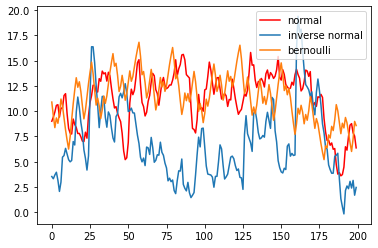

In [6]:
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import bernoulli, norm, norminvgauss

def arma22(N, alpha, beta, rnd, eps=0.5):
    inov = rnd.rvs(2*N)
    x = np.zeros(2*N)

    # arma22 mode
    for i in range(2,N*2):
        x[i] = (alpha[0] * x[i-1] + alpha[1]*x[i-2] + 
                    beta[0] * inov[i-1] + beta[1] * inov[i-2] + eps * inov[i])

    return x[N:]

N = 512
k = 10

alpha = [0.99, -0.1]
beta = [0.2, 0.0]
eps = 1

series = np.zeros((24*k, N))
y = np.zeros(24*k)
for i in range(8*k):
    series[i, :] = arma22(N, alpha, beta, norm(1.0), eps=eps)
    y[i] = 0
    
for i in range(8*k, 16*k):
    series[i, :] = arma22(N, alpha, beta, norminvgauss(1,0.5), eps=eps)
    y[i] = 1
    
for i in range(16*k, 24*k):
    series[i, :] = arma22(N, alpha, beta, bernoulli(0.5), eps=eps)*2
    y[i] = 2

plt.plot(series[3*k,:200], '-r')
plt.plot(series[8*k,:200])
plt.plot(series[-3*k,:200])
plt.legend(['normal', 'inverse normal', 'bernoulli'])

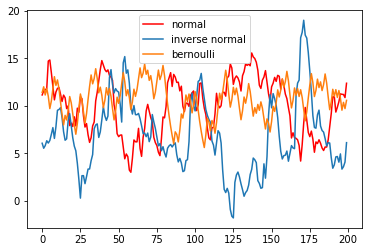

In [7]:
#Hold out data:
k = 8
hodl_series = np.zeros((24*k, N))
hodl_y = np.zeros(24*k)
for i in range(8*k):
    hodl_series[i, :] = arma22(N, alpha, beta, norm(1.0), eps=eps)
    hodl_y[i] = 0
    
for i in range(8*k, 16*k):
    hodl_series[i, :] = arma22(N, alpha, beta, norminvgauss(1,0.5), eps=eps)
    hodl_y[i] = 1
    
for i in range(16*k, 24*k):
    hodl_series[i, :] = arma22(N, alpha, beta, bernoulli(0.5), eps=eps)*2
    hodl_y[i] = 2
    

# hold out data
plt.plot(hodl_series[0,:200], '-r')
plt.plot(hodl_series[8*k,:200])
plt.plot(hodl_series[16*k,:200])
plt.legend(['normal', 'inverse normal', 'bernoulli'])

The scattering transform reduces the timeseries to a set of features, which we use for classification. The seperation between the series is more obvious looking at the log- of the features (see below). A support vector machine has an easy time classifying these processes.

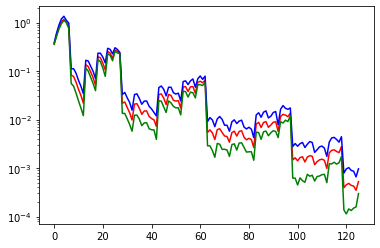

In [9]:
base_model = build_model_1d(N, 7,6, concatenate=True)
result = base_model.predict(hodl_series)

plt.semilogy(np.mean(result[:,0,:], axis=0), '-r')
plt.semilogy(np.mean(result[8*k:16*k,0,:], axis=0), '-b')
plt.semilogy(np.mean(result[16*k:,0,:], axis=0), '-g')

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

model = build_model_1d(N, 7, 6, concatenate=True)
result = np.log(model.predict(series))
X = result[:,0,:]
rdf = SVC()
rdf.fit(X,y)

hodl_result = np.log(model.predict(hodl_series))
hodl_X = hodl_result[:,0,:]
y_pred = rdf.predict(hodl_X)

cls1 = classification_report(hodl_y, y_pred)
print(cls1)

              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92        64
         1.0       0.98      0.97      0.98        64
         2.0       0.90      1.00      0.95        64

    accuracy                           0.95       192
   macro avg       0.95      0.95      0.95       192
weighted avg       0.95      0.95      0.95       192



Blusky build_model_1d creates a regular old keras model, which you can use like another, think VGG16 etc. The order (order < J) defines the depth of the network. If you want a deeper network, increase this parameter. Here we attach a set of fully connected layers to classify like we did previously with the SVM.

Dropping in a batch normalization here, seeems to be important for regularizong the problem.

In [ ]:
from tensorflow.keras import Input, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, Lambda
from tensorflow.keras.utils import to_categorical

early_stopping = EarlyStopping(monitor="val_loss", patience=50, verbose=True, 
                               restore_best_weights=True)

J = 7
order = 6
base_model = build_model_1d(N, J, order, concatenate=True)

dnn = Flatten()(base_model.output)

# let's add the "log" here like we did above
dnn = Lambda(lambda x : K.log(x))(dnn)

dnn = BatchNormalization()(dnn)

dnn = Dense(32, activation='linear', name='dnn1')(dnn)
dnn = Dense(3, activation='softmax', name='softmax')(dnn)

deep_model_1 = Model(inputs=base_model.input, outputs=dnn)
deep_model_1.compile(optimizer='rmsprop', loss='categorical_crossentropy')

history_1 = deep_model_1.fit(series, to_categorical(y), 
                             validation_data=(hodl_series, to_categorical(hodl_y)), 
                             callbacks=[early_stopping],
                             epochs=200)

y_pred = deep_model_1.predict(hodl_series)

cls_2 = classification_report(hodl_y, np.argmax(y_pred, axis=1))

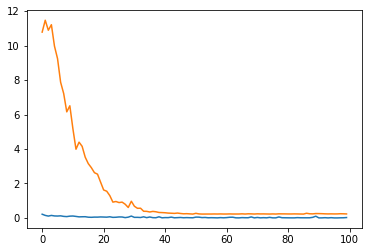

In [15]:
plt.plot(history_1.history['loss'][-100:])
plt.plot(history_1.history['val_loss'][-100:])

In [13]:
print(cls_2)

              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88        64
         1.0       0.94      0.95      0.95        64
         2.0       0.91      0.97      0.94        64

    accuracy                           0.92       192
   macro avg       0.92      0.92      0.92       192
weighted avg       0.92      0.92      0.92       192

